In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.font_manager as fm
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name())
from tqdm import tqdm
import re

In [2]:
# HTS
t18 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2018.csv', encoding='cp949')
t19 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2019.csv', encoding='cp949')
t20 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2020.csv', encoding='cp949')
t21 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2021.csv', encoding='cp949')

# 경기일정
sc = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_경기일정_2021.csv', encoding='cp949')

# 선수
p18 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2018.csv', encoding='cp949')
p19 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2019.csv', encoding='cp949')
p20 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2020.csv', encoding='cp949')
p21 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2021.csv', encoding='cp949')

# 타자 기본
h18 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2018.csv', encoding='cp949')
h19 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2019.csv', encoding='cp949')
h20 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2020.csv', encoding='cp949')
h21 = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2021.csv', encoding='cp949')

# 팀
team = pd.read_csv('data/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_팀.csv', encoding='cp949')

# 서브미션
submission = pd.read_excel('data/02_평가데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_평가데이터.xlsx')

In [3]:
hts = pd.concat([t18, t19, t20, t21], axis=0).reset_index(drop=True)
player = pd.concat([p18, p19, p20, p21], axis=0).reset_index(drop=True)
hit = pd.concat([h18, h19, h20, h21], axis=0).reset_index(drop=True)

In [4]:
hts.columns = ['연도', '경기코드', '타구코드', '선수코드', '팀코드', '이닝', '타구속도', '발사각도', '타격결과', '상대투수투구구속', '해당구장']
player.columns = ['연도', '선수코드', '선수명', '팀코드', '포지션', '나이', '연봉']
hit.columns = ['연도', '선수코드', '경기', '타석', '타수', '타율', '안타', '홈런', '루타', '장타율', '희생플라이', '볼넷', '삼진', '고의4구', '사구', '병살타']

- 76232 - 양의지
- 68050 - 강백호
- 75847 - 최정
- 67341 - 이정후
- 79192 - 채은성
- 78224 - 김재환
- 78513 - 전준우
- 76290 - 김현수
- 79215 - 박건우
- 67872 - 로맥

In [5]:
submission.loc[0,'OPS'] = 1.097
submission.PCODE[1]=76232;submission.PCODE[2]=68050;submission.PCODE[3]=75847;submission.PCODE[4]=67341;submission.PCODE[5]=79192
submission.PCODE[6]=78224;submission.PCODE[7]=78513;submission.PCODE[8]=76290;submission.PCODE[9]=79215;submission.PCODE[10]=67872;

### 돈 단위 통일(달러 -> 원)

In [6]:
player = player[-player['연봉'].isnull()]

In [7]:
player['money2'] = player['연봉'].str.replace('[가-힣]','').astype('int64')
player.loc[player['연봉'].str.endswith('달러'), 'money2'] = player.loc[player['연봉'].str.endswith('달러'), 'money2'].apply(lambda x : x * 0.12).astype('int64')
player['연봉'] = player['money2']
player.drop('money2', axis=1, inplace=True)

In [8]:
data = {'연도': 2020, '선수코드': 50802, '선수명': '화이트', '팀코드':'SK', '포지션':'내', '나이':31, '연봉':16000}
player = player.append(data, ignore_index=True)

In [9]:
hts.shape, player.shape, hit.shape

((120745, 11), (2635, 7), (1098, 16))

### 공인구 반발계수

In [10]:
# 2016~2018 : 0.4134∼0.4374
# 2019~ : 0.4034∼0.4234
# 2016~2018 평균 반발계수
print((0.4134 + 0.4374) / 2)   # 0.4254
# 2019~ 평균 반발계수
print((0.4034 + 0.4234) / 2)   # 0.4134

0.4254
0.4134


### 데이터 살펴보기

In [11]:
hts['상대팀코드'] = hts.경기코드.str[-5:-1]

In [12]:
for i in tqdm(range(hts.shape[0])):
    hts['상대팀코드'].iloc[i]=hts.iloc[i].상대팀코드.replace(hts.iloc[i].팀코드, '')

100%|█████████████████████████████████████████████████████████████████████████| 120745/120745 [09:50<00:00, 204.43it/s]


In [13]:
hts['날짜'] = '20' + hts.타구코드.str.split('_').str[0]
hts['날짜'] = pd.to_datetime(hts.날짜)
hts['월'] = hts.날짜.dt.month
hts['일'] = hts.날짜.dt.day
hts['시간'] = hts.날짜.dt.hour

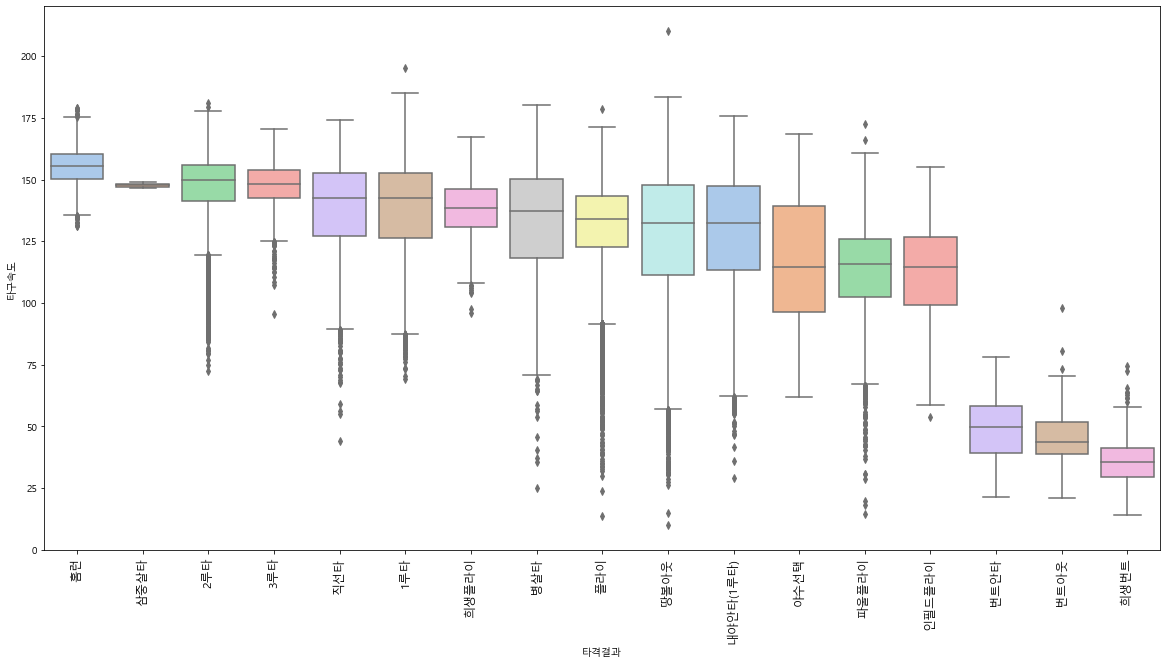

In [14]:
### 타격결과 별 타구속도의 분포
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x="타격결과", y="타구속도", data = hts, palette='pastel'
            ,order=hts.groupby('타격결과')['타구속도'].mean().reset_index().sort_values(by='타구속도',ascending=False).타격결과)
plt.xticks(fontsize=12, rotation='vertical')
plt.show()

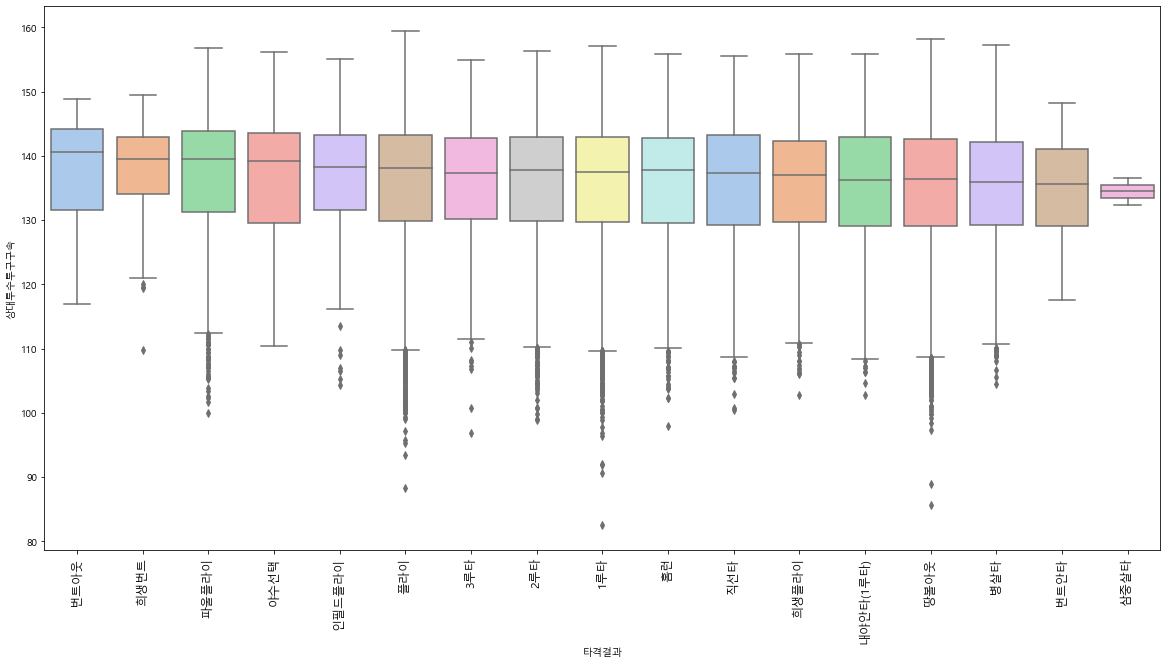

In [15]:
### 타격결과 별 투구구속의 분포
fig, ax= plt.subplots(figsize=(20,10))
sns.boxplot(x="타격결과", y="상대투수투구구속", data = hts, palette='pastel'
            ,order=hts.groupby('타격결과')['상대투수투구구속'].mean().reset_index().sort_values(by='상대투수투구구속',ascending=False).타격결과)
plt.xticks(fontsize=12, rotation='vertical')
plt.show()

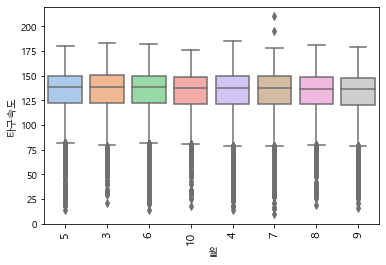

In [16]:
### 월별 타구속도 분포
sns.boxplot(x="월", y="타구속도", data = hts, palette='pastel'
            ,order=hts.groupby('월')['타구속도'].mean().reset_index().sort_values(by='타구속도',ascending=False).월)
plt.xticks(fontsize=12, rotation='vertical')
plt.show()

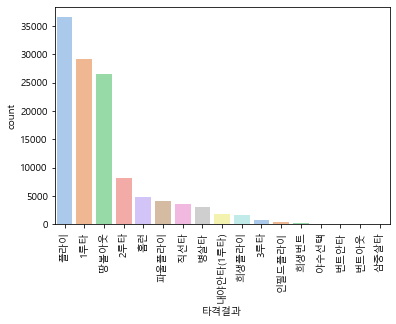

In [17]:
### 타구결과 분포
most_freq_aspect_labels = list(hts.groupby('타격결과')['타구속도'].count().sort_values(ascending=False).index)

ax1=sns.countplot(x='타격결과', data=hts, order=most_freq_aspect_labels, palette='pastel')
ax1.set_xticklabels(most_freq_aspect_labels, rotation='vertical')
plt.show()

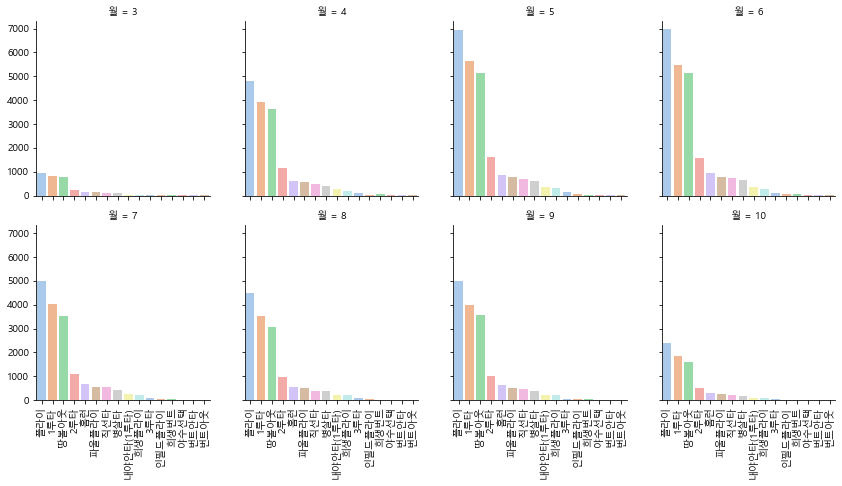

In [18]:
### 월별 타구결과 분포
grid1 = sns.FacetGrid(hts, col='월', col_wrap=4)

grid1.map_dataframe(sns.countplot, x='타격결과',order=most_freq_aspect_labels[:-1], palette='pastel')
grid1.set_xticklabels(most_freq_aspect_labels[:-1], rotation='vertical') # 작은 그래프들이 라벨들
plt.show()

In [19]:
tt = pd.merge(hts.groupby('월')['경기코드'].nunique().reset_index(),hts.groupby('월')['타격결과'].count().reset_index(),how='left',on='월')
tt['경기당타격'] = tt['타격결과']/tt['경기코드'] ; tt

,월,경기코드,타격결과,경기당타격
0,3,75,3340,44.533333
1,4,338,16187,47.890533
2,5,482,23240,48.215768
3,6,481,23053,47.927235
4,7,342,16593,48.517544
5,8,295,14518,49.213559
6,9,333,16179,48.585586
7,10,155,7635,49.258065


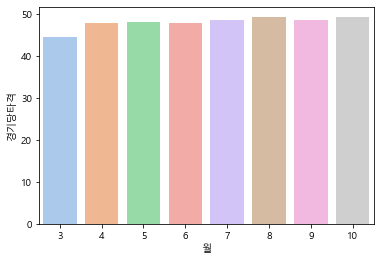

In [20]:
sns.barplot(x='월', y='경기당타격', data= tt, palette='pastel')
plt.show()

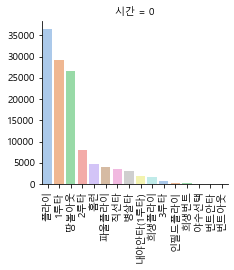

In [21]:
### 시간별 타구결과 분포
grid1 = sns.FacetGrid(hts, col='시간', col_wrap=6)

grid1.map_dataframe(sns.countplot, x='타격결과', order=most_freq_aspect_labels[:-1], palette='pastel')
grid1.set_xticklabels(most_freq_aspect_labels[:-1], rotation='vertical') #작은 그래프들이 라벨들
plt.show()

In [22]:
tt=pd.merge(hts.groupby('시간')['경기코드'].nunique().reset_index(), hts.groupby('시간')['타격결과'].count().reset_index(),how='left',on='시간')
tt['경기당타격'] = tt['타격결과']/tt['경기코드'] ; tt

,시간,경기코드,타격결과,경기당타격
0,0,2501,120745,48.278689


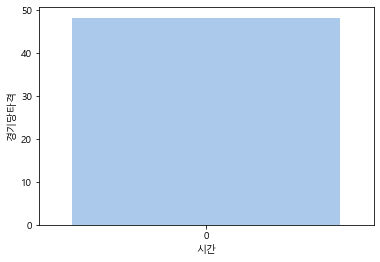

In [23]:
sns.barplot(x='시간', y='경기당타격', data= tt, palette='pastel')
plt.show()

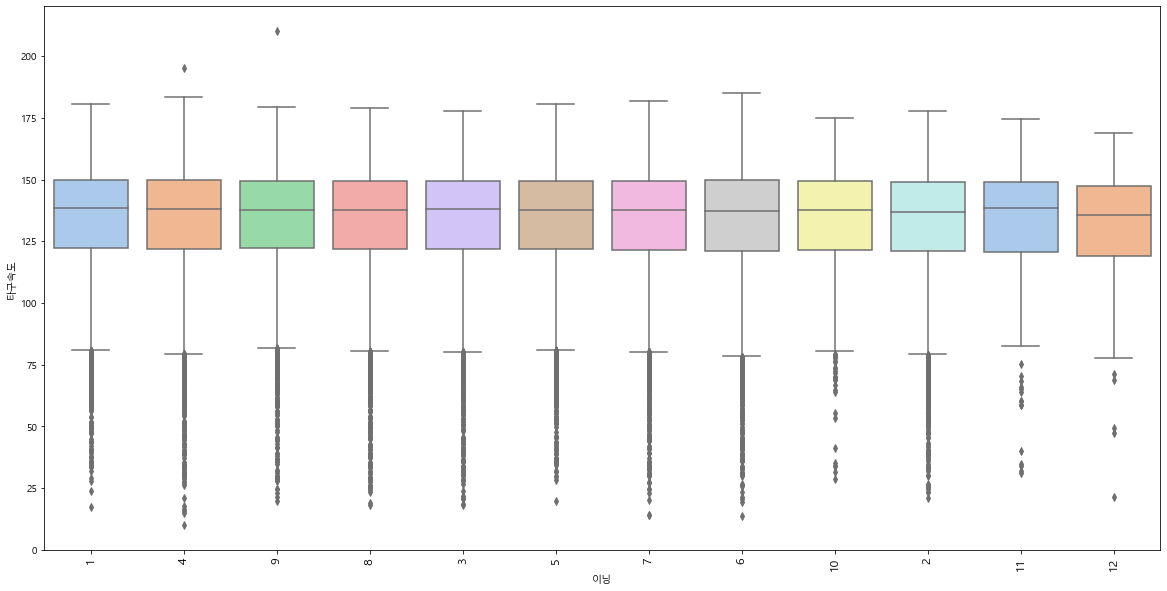

In [24]:
### 이닝별 타구속도 분포
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x="이닝", y="타구속도", data = hts, palette='pastel'
            ,order=hts.groupby('이닝')['타구속도'].mean().reset_index().sort_values(by='타구속도',ascending=False).이닝)
plt.xticks(fontsize=12, rotation='vertical')
plt.show()

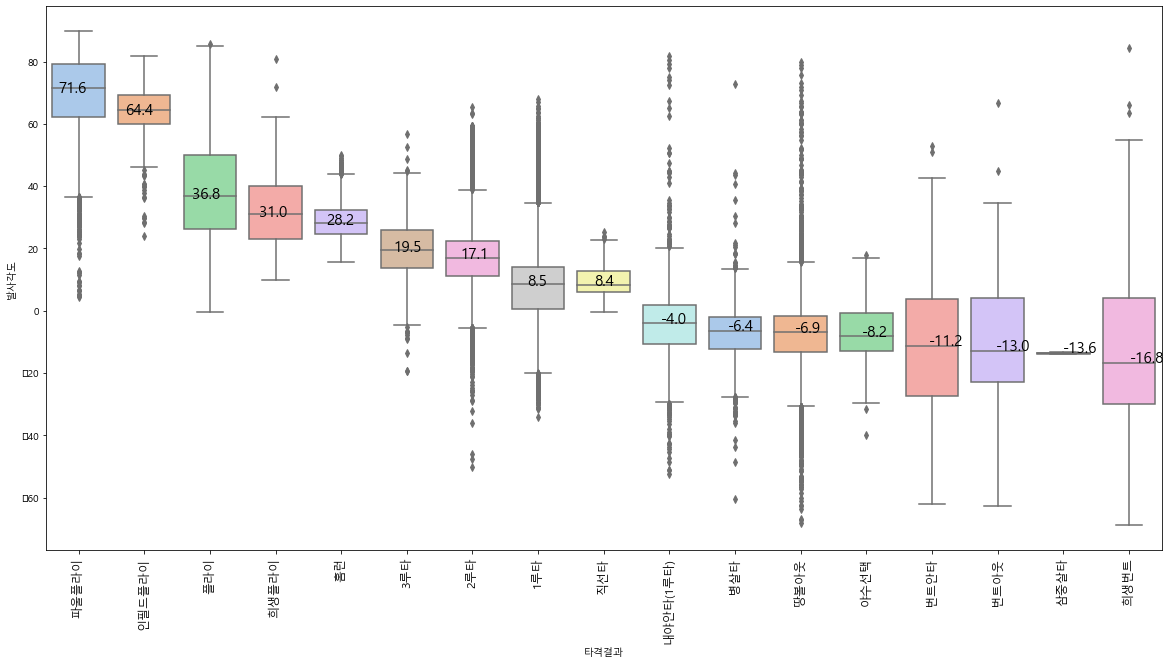

In [25]:
### 타격결과 별 발사각도 분포
fig, ax = plt.subplots(figsize=(20,10))
b = hts.groupby('타격결과')['발사각도'].median().reset_index().sort_values(by='발사각도',ascending=False).reset_index()
sns.boxplot(x="타격결과", y="발사각도", data=hts, palette='pastel'
            , order=b.타격결과)
for n in range(b.shape[0]):
    plt.text((n-0.3)*1.02, b['발사각도'][n]*0.98, 
             round(b['발사각도'][n],1), fontsize=15)
plt.xticks(fontsize=12, rotation='vertical')
plt.show()

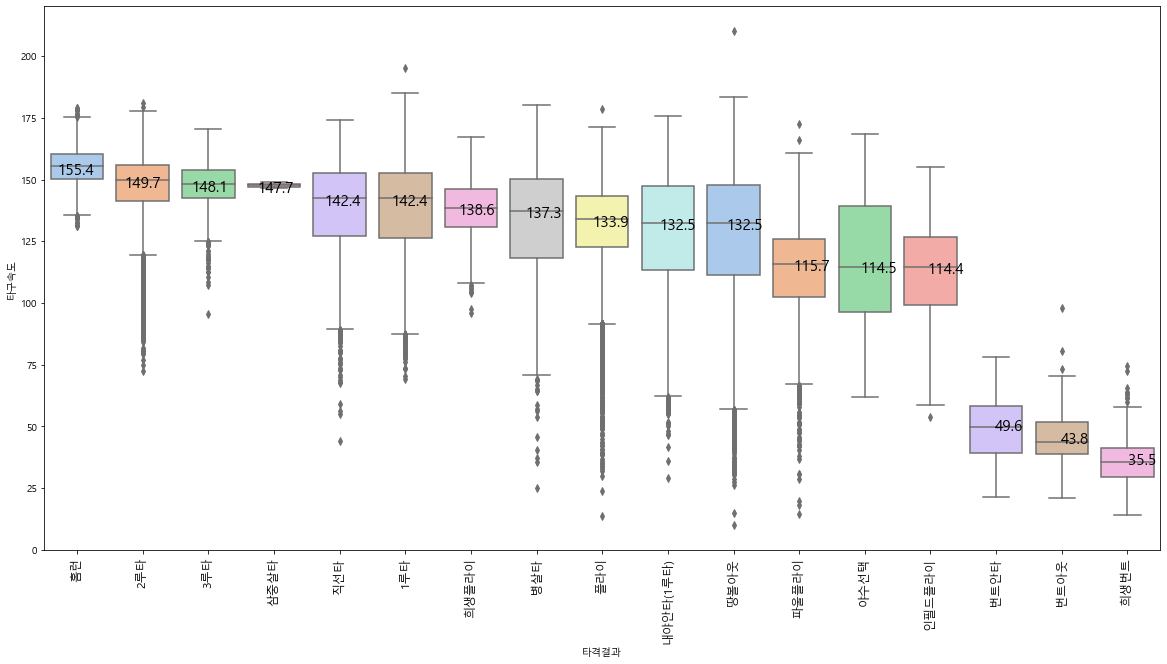

In [26]:
### 타격결과별 타구속도 분포
fig, ax = plt.subplots(figsize=(20,10))
b = hts.groupby('타격결과')['타구속도'].median().reset_index().sort_values(by='타구속도',ascending=False).reset_index()
sns.boxplot(x="타격결과", y="타구속도", data=hts, palette='pastel'
            ,order=b.타격결과)
for n in range(b.shape[0]):
    plt.text((n-0.3)*1.02, b['타구속도'][n]*0.98, 
             round(b['타구속도'][n],1), fontsize=15)
plt.xticks(fontsize=12, rotation='vertical')
plt.show()

In [27]:
### 구장별 홈런수
ga = hts.groupby('해당구장')['경기코드'].nunique().reset_index()
ga.columns = ['해당구장','경기수']
ga = pd.merge(hts[hts.타격결과=='홈런'].groupby('해당구장')['타격결과'].count().reset_index().sort_values(by='타격결과',ascending=False),ga,how='left',on='해당구장')
ga.columns = ['해당구장','홈런수','경기수']
ga['한경기홈런비율'] = (ga['홈런수']/ga['경기수'])
ga = ga.sort_values(by='한경기홈런비율',ascending=False);ga

,해당구장,홈런수,경기수,한경기홈런비율
9,마산,185,72,2.569444
1,문학,648,257,2.521401
2,대구,588,246,2.390244
7,창원,413,178,2.320225
3,사직,498,237,2.101266
4,수원,478,255,1.874510
5,대전,440,239,1.841004
6,광주,427,253,1.687747
8,고척,376,256,1.468750
0,잠실,679,508,1.336614


In [28]:
ga[['좌우','중간','좌우_중간','펜스']] = [0,0,0,0]
ga.loc[ga.해당구장=='마산',['좌우','중간','좌우_중간','펜스']] = [97,116,110,3.8]
ga.loc[ga.해당구장=='창원',['좌우','중간','좌우_중간','펜스']] = [101,122,123,3.3]
ga.loc[ga.해당구장=='문학',['좌우','중간','좌우_중간','펜스']] = [95,120,115,2.8]
ga.loc[ga.해당구장=='잠실',['좌우','중간','좌우_중간','펜스']] = [100,125,120,2.6]
ga.loc[ga.해당구장=='대구',['좌우','중간','좌우_중간','펜스']] = [99.5,122.5,107,3.6]
ga.loc[ga.해당구장=='사직',['좌우','중간','좌우_중간','펜스']] = [95,118,113,4.8]
ga.loc[ga.해당구장=='수원',['좌우','중간','좌우_중간','펜스']] = [98,120,115,4.0]
ga.loc[ga.해당구장=='대전',['좌우','중간','좌우_중간','펜스']] = [100,122,112,4.0]
ga.loc[ga.해당구장=='광주',['좌우','중간','좌우_중간','펜스']] = [99,121,116,2.6]
ga.loc[ga.해당구장=='고척',['좌우','중간','좌우_중간','펜스']] = [99,122,115.6,4]

In [29]:
ga.좌우.iloc[[0,1,2,3,4,5,6,7,9]].mean(), ga.중간.iloc[[0,1,2,3,4,5,6,7,9]].mean(), ga.좌우_중간.iloc[[0,1,2,3,4,5,6,7,9]].mean()

(98.27777777777777, 120.72222222222223, 114.55555555555556)

In [30]:
ga

,해당구장,홈런수,경기수,한경기홈런비율,좌우,중간,좌우_중간,펜스
9,마산,185,72,2.569444,97.0,116.0,110.0,3.8
1,문학,648,257,2.521401,95.0,120.0,115.0,2.8
2,대구,588,246,2.390244,99.5,122.5,107.0,3.6
7,창원,413,178,2.320225,101.0,122.0,123.0,3.3
3,사직,498,237,2.101266,95.0,118.0,113.0,4.8
4,수원,478,255,1.874510,98.0,120.0,115.0,4.0
5,대전,440,239,1.841004,100.0,122.0,112.0,4.0
6,광주,427,253,1.687747,99.0,121.0,116.0,2.6
8,고척,376,256,1.468750,99.0,122.0,115.6,4.0
0,잠실,679,508,1.336614,100.0,125.0,120.0,2.6


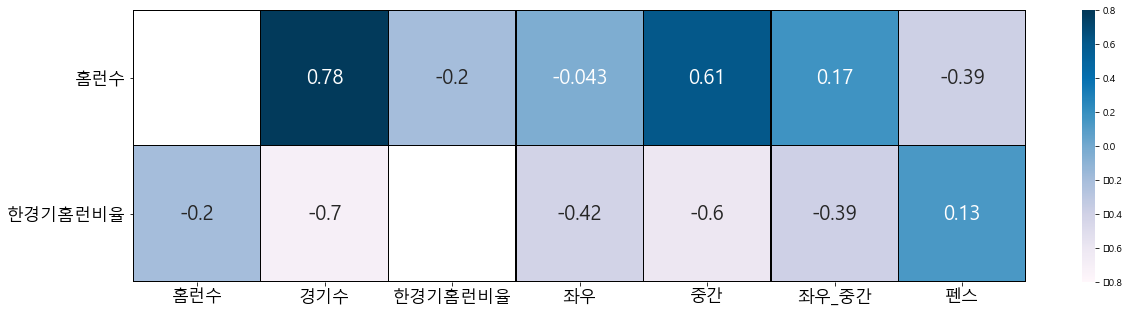

In [31]:
### 한경기 홈런 비율과 구장 규격과의 관계
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(ga.corr().iloc[[0,2],][ga.corr().iloc[[0,2],]!=1], cmap='PuBu', annot=True, vmin=-0.8, vmax=0.8, linewidths=.5, annot_kws = {"size" : 20}, linecolor='black')
plt.xticks(size=17) 
plt.yticks(rotation=0, size=17) 
plt.show()

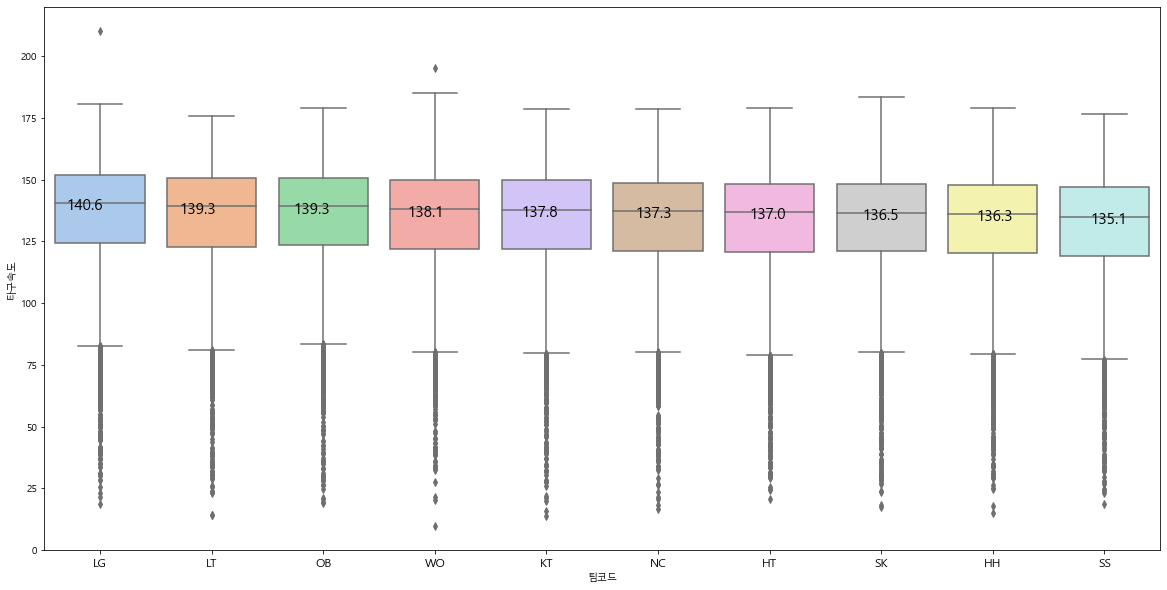

In [32]:
### 팀별 타구속도 분포
fig, ax = plt.subplots(figsize=(20,10))
b = hts.groupby('팀코드')['타구속도'].median().reset_index().sort_values(by='타구속도',ascending=False).reset_index()
sns.boxplot(x="팀코드", y="타구속도", data=hts, palette='pastel'
            ,order=b.팀코드)
for n in range(b.shape[0]):
    plt.text((n-0.3)*1.02, b['타구속도'][n]*0.98, 
             round(b['타구속도'][n],1), fontsize=15)
plt.xticks(fontsize=12)
plt.show()

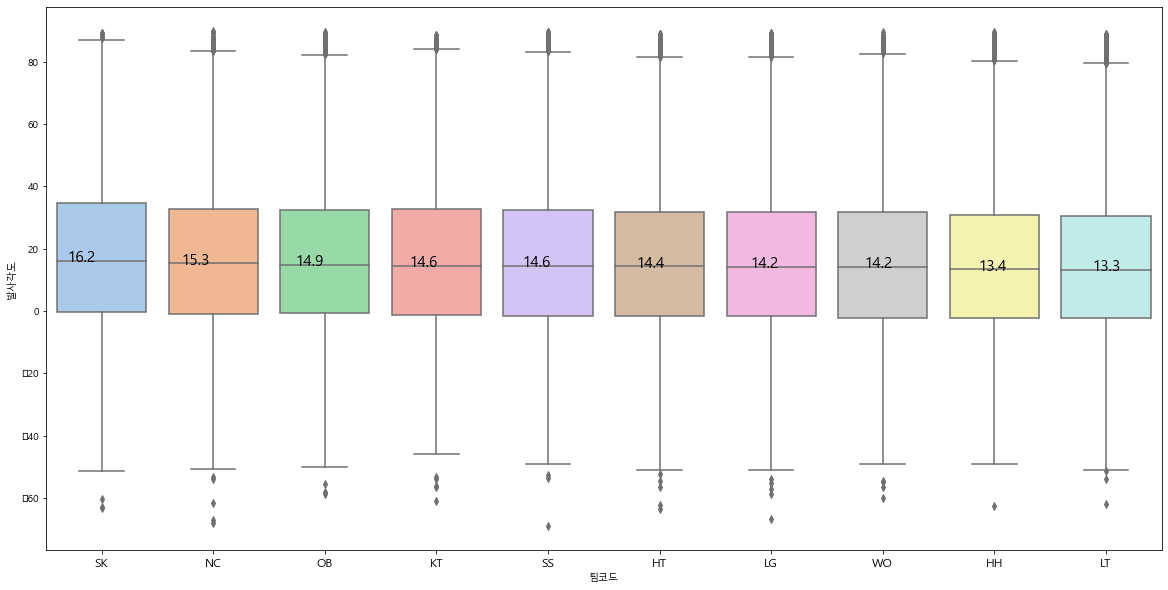

In [33]:
### 팀별 발사각도 분포
fig, ax = plt.subplots(figsize=(20,10))
b = hts.groupby('팀코드')['발사각도'].median().reset_index().sort_values(by='발사각도',ascending=False).reset_index()
sns.boxplot(x="팀코드", y="발사각도", data=hts, palette='pastel'
            ,order=b.팀코드)
for n in range(b.shape[0]):
    plt.text((n-0.3)*1.02, b['발사각도'][n]*0.98, 
             round(b['발사각도'][n],1), fontsize=15)
plt.xticks(fontsize=12)
plt.show()

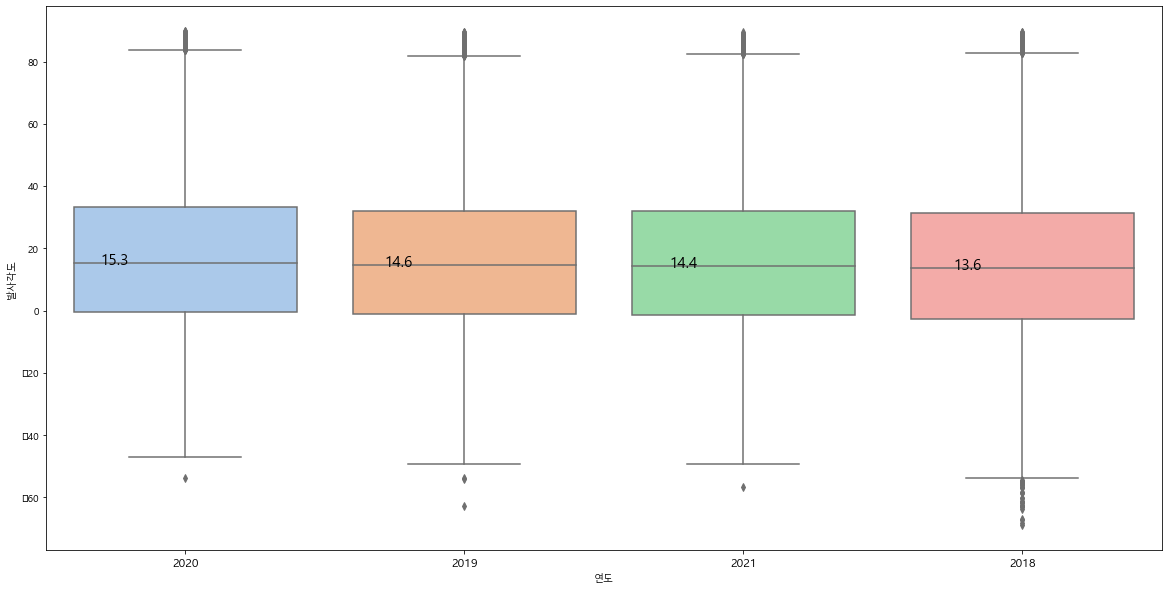

In [34]:
### 연도별 발사각도 분포
fig, ax = plt.subplots(figsize=(20,10))
b = hts.groupby('연도')['발사각도'].median().reset_index().sort_values(by='발사각도',ascending=False).reset_index()
sns.boxplot(x="연도", y="발사각도", data=hts, palette='pastel', order=b.연도)
for n in range(b.shape[0]):
    plt.text((n-0.3)*1.02, b['발사각도'][n]*0.98, 
             round(b['발사각도'][n],1), fontsize=15)
plt.xticks(fontsize=12)
plt.show()

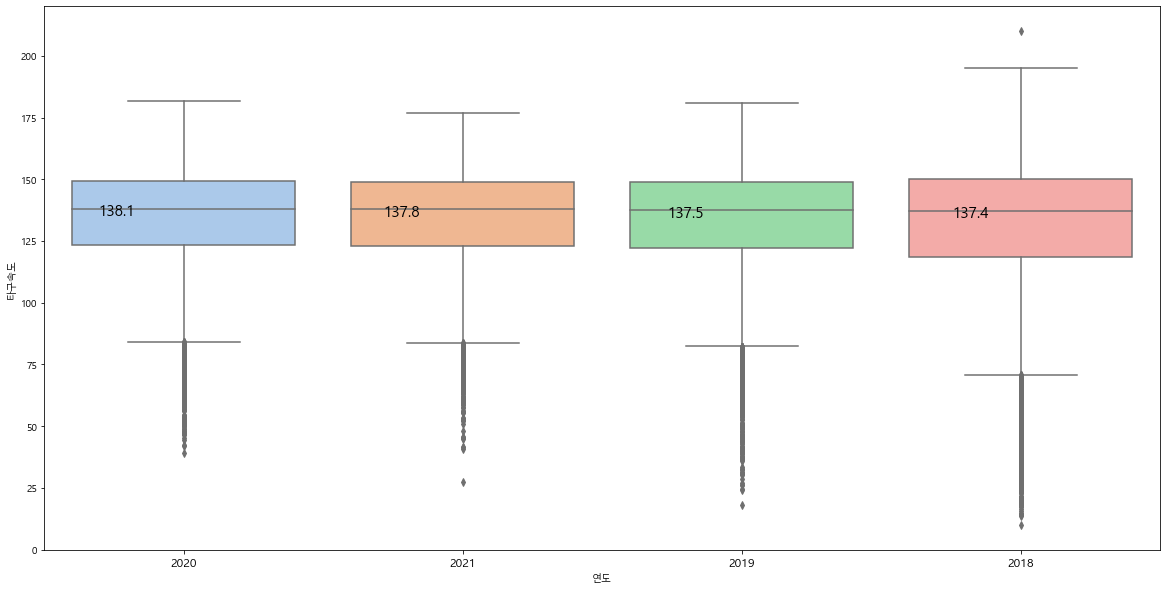

In [35]:
### 연도별 타구속도 분포
fig, ax = plt.subplots(figsize=(20,10))
b = hts.groupby('연도')['타구속도'].median().reset_index().sort_values(by='타구속도',ascending=False).reset_index()
sns.boxplot(x="연도", y="타구속도", data=hts, palette='pastel'
            ,order=b.연도)
for n in range(b.shape[0]):
    plt.text((n-0.3)*1.02, b['타구속도'][n]*0.98, 
             round(b['타구속도'][n],1), fontsize=15)
plt.xticks(fontsize=12)
plt.show()

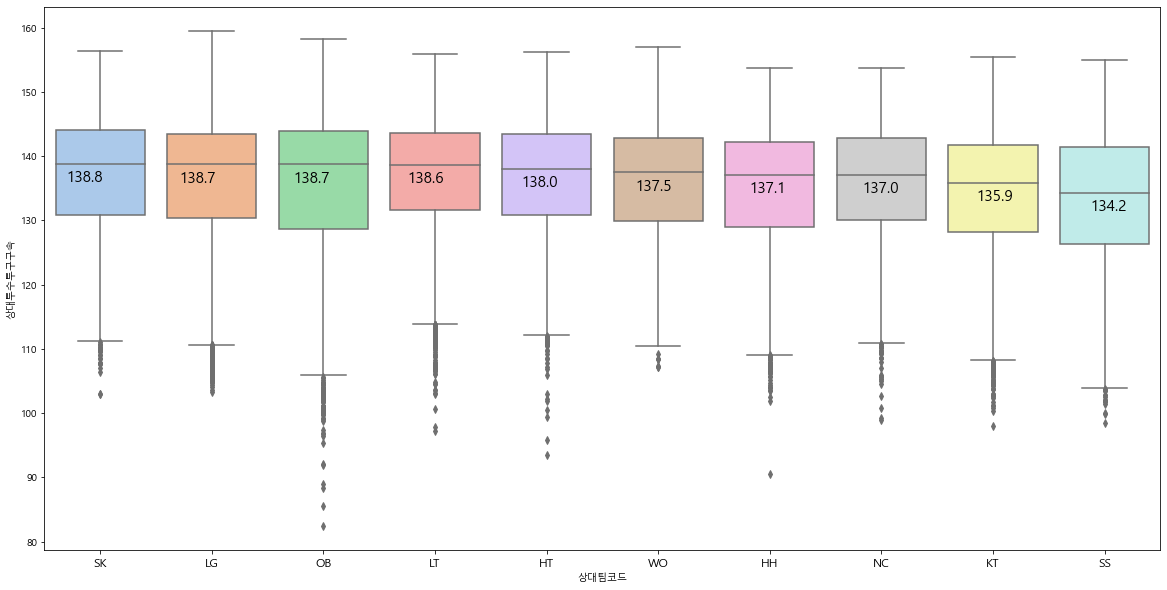

In [36]:
### 팀별 투구속도 분포
fig, ax = plt.subplots(figsize=(20,10))
b = hts.groupby('상대팀코드')['상대투수투구구속'].median().reset_index().sort_values(by='상대투수투구구속',ascending=False).reset_index()
sns.boxplot(x="상대팀코드", y="상대투수투구구속", data=hts, palette='pastel'
            ,order=b.상대팀코드)
for n in range(b.shape[0]):
    plt.text((n-0.3)*1.02, b['상대투수투구구속'][n]*0.98, 
             round(b['상대투수투구구속'][n],1), fontsize=15)
plt.xticks(fontsize=12)
plt.show()

###  기존 배럴 : 타구속도 & 발사각 고려
* 타구속도 : 98마일 이상
* 발사각 : 26~30도 사이

In [37]:
hts.head()

,연도,경기코드,타구코드,선수코드,팀코드,이닝,타구속도,발사각도,타격결과,상대투수투구구속,해당구장,상대팀코드,날짜,월,일,시간
0,2018,20180324HHWO0,180324_140436,62797,HH,1,131.50,42.7,플라이,149.59,고척,WO,2018-03-24,3,24,0
1,2018,20180324HHWO0,180324_140514,76753,HH,1,135.18,9.9,1루타,148.78,고척,WO,2018-03-24,3,24,0
2,2018,20180324HHWO0,180324_140647,71752,HH,1,152.41,2.1,1루타,148.59,고척,WO,2018-03-24,3,24,0
3,2018,20180324HHWO0,180324_140911,62700,HH,1,113.72,13.5,1루타,139.13,고척,WO,2018-03-24,3,24,0
4,2018,20180324HHWO0,180324_142050,68730,HH,2,54.11,16.4,번트안타,134.07,고척,WO,2018-03-24,3,24,0


In [38]:
# km을 마일로 변환
hts['타구속도'] = hts['타구속도'] * 0.621371192237334

In [39]:
# 타구속도
def br_condition(x):
    if (x >= 98):
        return 1
    else:
        return 0
        
hts['기존배럴_속도'] = hts['타구속도'].apply(br_condition)

In [40]:
hts['기존배럴_속도'].value_counts() / hts['기존배럴_속도'].count()

0    0.909454
1    0.090546
Name: 기존배럴_속도, dtype: float64

In [41]:
# BARREL_MLB식
hts['BARREL_mlb'] = 0

def BARREL_MLB(x):
    for i in range(hts.shape[0]):       
        if (x['타구속도'][i] >= 98) and (x['타구속도'][i] < 100):
            if (x['발사각도'][i] >= 26) and (x['발사각도'][i] <= 30):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 100) and (x['타구속도'][i] < 101):
            if (x['발사각도'][i] >= 25) and (x['발사각도'][i] <= 31):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 101) and (x['타구속도'][i] < 102):
            if (x['발사각도'][i] >= 24) and (x['발사각도'][i] <= 32):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 102) and (x['타구속도'][i] < 103):
            if (x['발사각도'][i] >= 23) and (x['발사각도'][i] <= 33):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 103) and (x['타구속도'][i] < 104):
            if (x['발사각도'][i] >= 22) and (x['발사각도'][i] <= 34):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 104) and (x['타구속도'][i] < 105):
            if (x['발사각도'][i] >= 21) and (x['발사각도'][i] <= 35):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 105) and (x['타구속도'][i] < 106):
            if (x['발사각도'][i] >= 20) and (x['발사각도'][i] <= 36):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 106) and (x['타구속도'][i] < 107):
            if (x['발사각도'][i] >= 19) and (x['발사각도'][i] <= 37):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 107) and (x['타구속도'][i] < 108):
            if (x['발사각도'][i] >= 18) and (x['발사각도'][i] <= 38):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 108) and (x['타구속도'][i] < 109):
            if (x['발사각도'][i] >= 17) and (x['발사각도'][i] <= 39):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 109) and (x['타구속도'][i] < 110):
            if (x['발사각도'][i] >= 16) and (x['발사각도'][i] <= 40):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 110) and (x['타구속도'][i] < 111):
            if (x['발사각도'][i] >= 15) and (x['발사각도'][i] <= 41):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 111) and (x['타구속도'][i] < 112):
            if (x['발사각도'][i] >= 14) and (x['발사각도'][i] <= 42):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 112) and (x['타구속도'][i] < 113):
            if (x['발사각도'][i] >= 13) and (x['발사각도'][i] <= 43):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 113) and (x['타구속도'][i] < 114):
            if (x['발사각도'][i] >= 12) and (x['발사각도'][i] <= 44):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 114) and (x['타구속도'][i] < 115):
            if (x['발사각도'][i] >= 10) and (x['발사각도'][i] <= 46):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif (x['타구속도'][i] >= 115) and (x['타구속도'][i] < 116):
            if (x['발사각도'][i] >= 9) and (x['발사각도'][i] <= 48):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0
        elif x['타구속도'][i] >= 116:
            if (x['발사각도'][i] >= 8) and (x['발사각도'][i] <= 50):
                hts['BARREL_mlb'][i] = 1
            else:
                hts['BARREL_mlb'][i] = 0

In [42]:
BARREL_MLB(hts)

In [43]:
hts['BARREL_mlb'].value_counts() / hts['BARREL_mlb'].count()

0    0.993109
1    0.006891
Name: BARREL_mlb, dtype: float64

### OPS = 출루율 + 장타율

In [44]:
# 출루율 = (안타 + 볼넷 + 몸에 맞는 볼) / (타수 + 볼넷 + 몸에 맞는 볼 + 희생플라이)
# on base percentage
hit['출루율'] = (hit['안타'] + hit['볼넷'] + hit['사구']) / (hit['타수'] + hit['볼넷'] + hit['사구'] + hit['희생플라이'])
hit['OPS'] = hit['장타율'] + hit['출루율']

In [45]:
team.columns = ['연도', '팀코드', '팀이름']
hit = hit.merge(player, on=['연도', '선수코드'], how='left')
hit = hit.merge(team, on=['연도', '팀코드'], how='left')

### 스탯티즈 크롤링을 위한 준비

In [46]:
### KBO 선수 정보
p_info = pd.read_excel('data/선수정보.xlsx')
p_info = p_info.fillna(0)
p_info['등번호'] = p_info['등번호'].astype(int)

p_info.columns = ['등번호', '선수명', '팀이름', '포지션', '생년월일', '체격', '출신교']

In [47]:
hp = hit.query('연도 == 2021').merge(p_info.drop('포지션', axis=1), on=['팀이름', '선수명'], how='left')
# 중복되는 정보 제거

hp = hp.drop(hp.index[159])

In [48]:
hit = hit.merge(hp[['생년월일', '선수코드']], on=['선수코드'], how='left')

In [49]:
hit.loc[hit['선수코드']==60100, '생년월일'] = '1988-05-09' # 백창수
hit.loc[hit['선수코드']==60184, '생년월일'] = '1991-05-17' # 김창혁
hit.loc[hit['선수코드']==60456, '생년월일'] = '1988-01-02' # 백상원
hit.loc[hit['선수코드']==60605, '생년월일'] = '1987-05-10' # 홍재호
hit.loc[hit['선수코드']==60648, '생년월일'] = '1991-06-30' # 이인행

hit.loc[hit['선수코드']==60805, '생년월일'] = '1987-03-28' # 최윤석
hit.loc[hit['선수코드']==61104, '생년월일'] = '1988-03-23' # 정병곤
hit.loc[hit['선수코드']==61114, '생년월일'] = '1989-01-14' # 김재율
hit.loc[hit['선수코드']==61204, '생년월일'] = '1988-06-24' # 김동한
hit.loc[hit['선수코드']==61366, '생년월일'] = '1992-08-02' # 홍성갑

hit.loc[hit['선수코드']==61566, '생년월일'] = '1992-11-20' # 허일
hit.loc[hit['선수코드']==61591, '생년월일'] = '1987-06-18' # 김사훈
hit.loc[hit['선수코드']==61652, '생년월일'] = '1988-05-12' # 윤정우
hit.loc[hit['선수코드']==61865, '생년월일'] = '1989-01-02' # 이윤재
hit.loc[hit['선수코드']==61962, '생년월일'] = '1988-09-26' # 김정후

hit.loc[hit['선수코드']==62016, '생년월일'] = '1989-07-05' # 윤병호
hit.loc[hit['선수코드']==62164, '생년월일'] = '1989-09-17' # 서상우
hit.loc[hit['선수코드']==62356, '생년월일'] = '1993-01-26' # 김규민
hit.loc[hit['선수코드']==62409, '생년월일'] = '1989-02-22' # 박찬도
hit.loc[hit['선수코드']==62537, '생년월일'] = '1990-02-22' # 윤수강

hit.loc[hit['선수코드']==62797, '생년월일'] = '1989-05-02' # 양성우
hit.loc[hit['선수코드']==62917, '생년월일'] = '1993-06-09' # 강구성
hit.loc[hit['선수코드']==62921, '생년월일'] = '1993-04-11' # 박헌욱
hit.loc[hit['선수코드']==62929, '생년월일'] = '1993-08-11' # 이민호
hit.loc[hit['선수코드']==62934, '생년월일'] = '1993-05-01' # 김성욱

hit.loc[hit['선수코드']==63088, '생년월일'] = '1987-09-10' # 김진곤
hit.loc[hit['선수코드']==63360, '생년월일'] = '1993-09-23' # 장시윤
hit.loc[hit['선수코드']==63448, '생년월일'] = '1993-01-31' # 김영환
hit.loc[hit['선수코드']==63593, '생년월일'] = '1990-02-23' # 조홍석
hit.loc[hit['선수코드']==64022, '생년월일'] = '1995-09-01' # 안중열

hit.loc[hit['선수코드']==64117, '생년월일'] = '1991-07-21' # 양원혁
hit.loc[hit['선수코드']==64300, '생년월일'] = '1995-10-17' # 김하성
hit.loc[hit['선수코드']==64346, '생년월일'] = '1995-09-30' # 임병욱
hit.loc[hit['선수코드']==64410, '생년월일'] = '1990-07-09' # 백승민
hit.loc[hit['선수코드']==64499, '생년월일'] = '1991-08-30' # 김재현

hit.loc[hit['선수코드']==64504, '생년월일'] = '1992-02-24' # 오윤석
hit.loc[hit['선수코드']==64724, '생년월일'] = '1991-01-09' # 박준혁
hit.loc[hit['선수코드']==64944, '생년월일'] = '1995-08-28' # 박광열
hit.loc[hit['선수코드']==65109, '생년월일'] = '1995-05-26' # 백승현
hit.loc[hit['선수코드']==65115, '생년월일'] = '1996-02-12' # 안익훈

hit.loc[hit['선수코드']==65136, '생년월일'] = '1991-10-12' # 박지규
hit.loc[hit['선수코드']==65618, '생년월일'] = '1991-07-23' # 황인준
hit.loc[hit['선수코드']==66354, '생년월일'] = '1997-11-11' # 주효상
hit.loc[hit['선수코드']==66392, '생년월일'] = '1993-05-12' # 김종덕
hit.loc[hit['선수코드']==66406, '생년월일'] = '1993-08-14' # 안주형

hit.loc[hit['선수코드']==66462, '생년월일'] = '1993-10-27' # 김성훈
hit.loc[hit['선수코드']==66508, '생년월일'] = '1991-12-12' # 나경민
hit.loc[hit['선수코드']==66615, '생년월일'] = '1997-07-01' # 류승현
hit.loc[hit['선수코드']==66643, '생년월일'] = '1987-01-26' # 헥터
hit.loc[hit['선수코드']==66662, '생년월일'] = '1998-01-25' # 신범수

hit.loc[hit['선수코드']==66704, '생년월일'] = '1997-06-10' # 김태연
hit.loc[hit['선수코드']==66706, '생년월일'] = '1993-09-30' # 장진혁
hit.loc[hit['선수코드']==66715, '생년월일'] = '1994-01-28' # 김인환
hit.loc[hit['선수코드']==66716, '생년월일'] = '1993-08-09' # 정경운
hit.loc[hit['선수코드']==66864, '생년월일'] = '1997-01-27' # 안상현

hit.loc[hit['선수코드']==66992, '생년월일'] = '1993-04-10' # 조원빈
hit.loc[hit['선수코드']==67025, '생년월일'] = '1990-05-24' # 로하스
hit.loc[hit['선수코드']==67207, '생년월일'] = '1998-08-05' # 이병휘(이유찬)
hit.loc[hit['선수코드']==67394, '생년월일'] = '1989-11-10' # 초이스
hit.loc[hit['선수코드']==67450, '생년월일'] = '1986-07-28' # 러프

hit.loc[hit['선수코드']==67454, '생년월일'] = '1994-08-20' # 나원탁
hit.loc[hit['선수코드']==67539, '생년월일'] = '1998-03-16' # 나종덕(나균안)
hit.loc[hit['선수코드']==67598, '생년월일'] = '1990-08-07' # 번즈
hit.loc[hit['선수코드']==67610, '생년월일'] = '1999-02-28' # 김석환
hit.loc[hit['선수코드']==67640, '생년월일'] = '1998-03-02' # 유승철

hit.loc[hit['선수코드']==67650, '생년월일'] = '1984-06-12' # 버나디나
hit.loc[hit['선수코드']==67935, '생년월일'] = '1987-09-23' # 스크럭스
hit.loc[hit['선수코드']==67944, '생년월일'] = '1991-10-20' # 신진호
hit.loc[hit['선수코드']==68069, '생년월일'] = '1999-04-16' # 고명성
hit.loc[hit['선수코드']==68103, '생년월일'] = '1985-04-12' # 가르시아

hit.loc[hit['선수코드']==68119, '생년월일'] = '1997-02-20' # 문성주
hit.loc[hit['선수코드']==68244, '생년월일'] = '1988-11-25' # 파레디스
hit.loc[hit['선수코드']==68245, '생년월일'] = '1986-07-24' # 반슬라이크
hit.loc[hit['선수코드']==68330, '생년월일'] = '1999-03-16' # 예진원
hit.loc[hit['선수코드']==68345, '생년월일'] = '1987-09-28' # 샌즈

hit.loc[hit['선수코드']==68730, '생년월일'] = '1989-05-18' # 호잉
hit.loc[hit['선수코드']==68901, '생년월일'] = '1999-01-03' # 이인혁
hit.loc[hit['선수코드']==68904, '생년월일'] = '2000-01-30' # 오영수
hit.loc[hit['선수코드']==68906, '생년월일'] = '1998-02-06' # 김철호
hit.loc[hit['선수코드']==68912, '생년월일'] = '1999-11-02' # 김형준

hit.loc[hit['선수코드']==70410, '생년월일'] = '1981-03-25' # 김주찬
hit.loc[hit['선수코드']==70553, '생년월일'] = '1981-06-04' # 박기혁
hit.loc[hit['선수코드']==70756, '생년월일'] = '1981-11-25' # 이범호
hit.loc[hit['선수코드']==71184, '생년월일'] = '1981-09-01' # 이성우
hit.loc[hit['선수코드']==71432, '생년월일'] = '1979-01-28' # 박한이

hit.loc[hit['선수코드']==71552, '생년월일'] = '1983-02-15' # 최준석
hit.loc[hit['선수코드']==71752, '생년월일'] = '1982-05-29' # 김태균
hit.loc[hit['선수코드']==71842, '생년월일'] = '1982-12-24' # 정상호
hit.loc[hit['선수코드']==72133, '생년월일'] = '1979-04-21' # 박용택
hit.loc[hit['선수코드']==72456, '생년월일'] = '1983-12-01' # 손주인

hit.loc[hit['선수코드']==72466, '생년월일'] = '1983-07-27' # 조동찬
hit.loc[hit['선수코드']==72546, '생년월일'] = '1983-07-05' # 문규현
hit.loc[hit['선수코드']==72860, '생년월일'] = '1981-08-21' # 이대수
hit.loc[hit['선수코드']==73153, '생년월일'] = '1983-07-19' # 이대형
hit.loc[hit['선수코드']==73213, '생년월일'] = '1980-10-19' # 손시헌

hit.loc[hit['선수코드']==73339, '생년월일'] = '1980-06-18' # 이종욱
hit.loc[hit['선수코드']==73342, '생년월일'] = '1980-07-10' # 이택근
hit.loc[hit['선수코드']==73606, '생년월일'] = '1984-03-21' # 서동욱
hit.loc[hit['선수코드']==74215, '생년월일'] = '1985-09-04' # 윤석민
hit.loc[hit['선수코드']==74605, '생년월일'] = '1985-12-15' # 김주형

hit.loc[hit['선수코드']==74729, '생년월일'] = '1985-08-17' # 최진행
hit.loc[hit['선수코드']==74823, '생년월일'] = '1985-07-17' # 임훈
hit.loc[hit['선수코드']==74846, '생년월일'] = '1981-07-21' # 박정권
hit.loc[hit['선수코드']==75808, '생년월일'] = '1982-10-02' # 정근우
hit.loc[hit['선수코드']==76158, '생년월일'] = '1988-01-11' # 최승준

hit.loc[hit['선수코드']==76368, '생년월일'] = '1987-11-21' # 유재신
hit.loc[hit['선수코드']==76509, '생년월일'] = '1987-06-22' # 김문호
hit.loc[hit['선수코드']==76746, '생년월일'] = '1984-01-27' # 김태완
hit.loc[hit['선수코드']==76753, '생년월일'] = '1983-06-24' # 송광민
hit.loc[hit['선수코드']==76869, '생년월일'] = '1987-11-07' # 김재현

hit.loc[hit['선수코드']==77462, '생년월일'] = '1988-06-24' # 김동욱
hit.loc[hit['선수코드']==77463, '생년월일'] = '1982-10-11' # 채태인
hit.loc[hit['선수코드']==77466, '생년월일'] = '1989-02-04' # 최원제
hit.loc[hit['선수코드']==77654, '생년월일'] = '1988-06-17' # 이준수
hit.loc[hit['선수코드']==78168, '생년월일'] = '1989-08-22' # 서건창

hit.loc[hit['선수코드']==78467, '생년월일'] = '1985-10-11' # 이영욱
hit.loc[hit['선수코드']==78517, '생년월일'] = '1989-04-29' # 하준호
hit.loc[hit['선수코드']==78566, '생년월일'] = '1989-02-15' # 황진수
hit.loc[hit['선수코드']==78753, '생년월일'] = '1988-08-09' # 김지열
hit.loc[hit['선수코드']==78756, '생년월일'] = '1989-07-07' # 오선진

hit.loc[hit['선수코드']==79113, '생년월일'] = '1990-05-20' # 문선재
hit.loc[hit['선수코드']==79130, '생년월일'] = '1990-10-23' # 강지광
hit.loc[hit['선수코드']==79198, '생년월일'] = '1986-06-23' # 윤진호
hit.loc[hit['선수코드']==79300, '생년월일'] = '1986-08-23' # 김지수
hit.loc[hit['선수코드']==79334, '생년월일'] = '1990-05-14' # 장영석

hit.loc[hit['선수코드']==79356, '생년월일'] = '1987-01-01' # 박헌도
hit.loc[hit['선수코드']==79364, '생년월일'] = '1986-03-30' # 김종민
hit.loc[hit['선수코드']==79453, '생년월일'] = '1986-10-13' # 오정복
hit.loc[hit['선수코드']==79465, '생년월일'] = '1986-06-27' # 배영섭
hit.loc[hit['선수코드']==79530, '생년월일'] = '1990-10-09' # 양종민

hit.loc[hit['선수코드']==79705, '생년월일'] = '1985-12-04' # 김회성
hit.loc[hit['선수코드']==99606, '생년월일'] = '1980-06-27' # 정성훈
hit.loc[hit['선수코드']==99810, '생년월일'] = '1980-06-15' # 이진영
hit.loc[hit['선수코드']==62499, '생년월일'] = '1993-03-27' # 이현동
hit.loc[hit['선수코드']==62558, '생년월일'] = '1994-07-31' # 김준태

hit.loc[hit['선수코드']==62668, '생년월일'] = '1989-02-25' # 윤해진
hit.loc[hit['선수코드']==63558, '생년월일'] = '1994-04-01' # 정준혁
hit.loc[hit['선수코드']==63636, '생년월일'] = '1990-01-08' # 고장혁
hit.loc[hit['선수코드']==63703, '생년월일'] = '1994-12-24' # 박한결
hit.loc[hit['선수코드']==63903, '생년월일'] = '1994-07-13' # 유영준

hit.loc[hit['선수코드']==64011, '생년월일'] = '1992-01-25' # 안승한
hit.loc[hit['선수코드']==64164, '생년월일'] = '1995-05-07' # 류형우
hit.loc[hit['선수코드']==64260, '생년월일'] = '1995-07-31' # 김경호
hit.loc[hit['선수코드']==64493, '생년월일'] = '1991-12-12' # 최선호
hit.loc[hit['선수코드']==64706, '생년월일'] = '1991-09-06' # 이창열

hit.loc[hit['선수코드']==64803, '생년월일'] = '1991-05-29' # 임재현
hit.loc[hit['선수코드']==65062, '생년월일'] = '1990-09-16' # 김재윤
hit.loc[hit['선수코드']==65643, '생년월일'] = '1992-07-08' # 문경찬
hit.loc[hit['선수코드']==65869, '생년월일'] = '1992-06-07' # 이현석
hit.loc[hit['선수코드']==66409, '생년월일'] = '1993-08-03' # 이성규

hit.loc[hit['선수코드']==66504, '생년월일'] = '1996-05-14' # 이찬건
hit.loc[hit['선수코드']==66707, '생년월일'] = '1997-03-03' # 박상언
hit.loc[hit['선수코드']==67006, '생년월일'] = '1998-05-29' # 안치영
hit.loc[hit['선수코드']==67123, '생년월일'] = '1998-07-01' # 전준호
hit.loc[hit['선수코드']==67202, '생년월일'] = '1998-12-20' # 박유연

hit.loc[hit['선수코드']==68407, '생년월일'] = '1999-09-27' # 공민규
hit.loc[hit['선수코드']==68556, '생년월일'] = '1995-11-16' # 정성종
hit.loc[hit['선수코드']==68614, '생년월일'] = '1999-03-27' # 오정환
hit.loc[hit['선수코드']==68646, '생년월일'] = '1999-02-13' # 한준수
hit.loc[hit['선수코드']==68700, '생년월일'] = '1999-03-31' # 이원석

hit.loc[hit['선수코드']==68868, '생년월일'] = '1999-03-25' # 최준우
hit.loc[hit['선수코드']==69056, '생년월일'] = '2000-04-13' # 박민석
hit.loc[hit['선수코드']==69150, '생년월일'] = '1991-07-16' # 조셉
hit.loc[hit['선수코드']==69165, '생년월일'] = '1987-02-22' # 페게로
hit.loc[hit['선수코드']==69203, '생년월일'] = '2000-10-28' # 송승환

hit.loc[hit['선수코드']==69238, '생년월일'] = '2000-12-06' # 김대한
hit.loc[hit['선수코드']==69306, '생년월일'] = '1996-03-05' # 김주형
hit.loc[hit['선수코드']==69403, '생년월일'] = '2000-04-13' # 양우현
hit.loc[hit['선수코드']==69405, '생년월일'] = '1990-07-15' # 윌리엄슨
hit.loc[hit['선수코드']==69442, '생년월일'] = '2000-04-14' # 김도환

hit.loc[hit['선수코드']==69517, '생년월일'] = '2000-08-11' # 고승민
hit.loc[hit['선수코드']==69530, '생년월일'] = '1991-11-02' # 아수아헤
hit.loc[hit['선수코드']==69569, '생년월일'] = '1990-07-29' # 윌슨
hit.loc[hit['선수코드']==69605, '생년월일'] = '1987-08-14' # 해즐베이커
hit.loc[hit['선수코드']==69727, '생년월일'] = '2000-03-18' # 변우혁

hit.loc[hit['선수코드']==69802, '생년월일'] = '1996-06-17' # 최경모
hit.loc[hit['선수코드']==69804, '생년월일'] = '1995-11-21' # 채현우
hit.loc[hit['선수코드']==69860, '생년월일'] = '1993-05-12' # 김성민
hit.loc[hit['선수코드']==69901, '생년월일'] = '1989-02-09' # 스몰린스키
hit.loc[hit['선수코드']==69950, '생년월일'] = '1991-09-02' # 베탄코트

hit.loc[hit['선수코드']==79234, '생년월일'] = '1990-06-07' # 김진형
hit.loc[hit['선수코드']==50066, '생년월일'] = '2001-04-13' # 강현우
hit.loc[hit['선수코드']==50204, '생년월일'] = '2000-09-07' # 박지훈
hit.loc[hit['선수코드']==50293, '생년월일'] = '1997-05-25' # 양찬열
hit.loc[hit['선수코드']==50300, '생년월일'] = '1989-09-18' # 모터

hit.loc[hit['선수코드']==50350, '생년월일'] = '1994-01-23' # 러셀
hit.loc[hit['선수코드']==50468, '생년월일'] = '1989-07-20' # 살라디노
hit.loc[hit['선수코드']==50469, '생년월일'] = '1991-10-28' # 팔카
hit.loc[hit['선수코드']==50600, '생년월일'] = '2000-05-02' # 홍종표
hit.loc[hit['선수코드']==50730, '생년월일'] = '1986-05-15' # 반즈

hit.loc[hit['선수코드']==50802, '생년월일'] = '1990-10-29' # 화이트
hit.loc[hit['선수코드']==50819, '생년월일'] = '1997-06-15' # 이거연
hit.loc[hit['선수코드']==50848, '생년월일'] = '2001-04-30' # 김성민
hit.loc[hit['선수코드']==50868, '생년월일'] = '1996-07-16' # 류효승
hit.loc[hit['선수코드']==50996, '생년월일'] = '2001-05-30' # 박시원

hit.loc[hit['선수코드']==63339, '생년월일'] = '1994-02-12' # 김민준
hit.loc[hit['선수코드']==63913, '생년월일'] = '1990-07-30' # 최재원
hit.loc[hit['선수코드']==64100, '생년월일'] = '1995-12-06' # 박재욱
hit.loc[hit['선수코드']==64209, '생년월일'] = '1995-02-18' # 정기훈
hit.loc[hit['선수코드']==64704, '생년월일'] = '1995-02-08' # 노태형

hit.loc[hit['선수코드']==65096, '생년월일'] = '1995-06-26' # 정주후
hit.loc[hit['선수코드']==65522, '생년월일'] = '1995-02-27' # 김강현
hit.loc[hit['선수코드']==67063, '생년월일'] = '1998-01-31' # 문상인
hit.loc[hit['선수코드']==68003, '생년월일'] = '1999-08-30' # 박준혁
hit.loc[hit['선수코드']==68211, '생년월일'] = '1995-02-08' # 이승민

hit.loc[hit['선수코드']==68504, '생년월일'] = '1995-06-03' # 이호연
hit.loc[hit['선수코드']==68701, '생년월일'] = '2000-01-13' # 김진욱
hit.loc[hit['선수코드']==69439, '생년월일'] = '1992-03-05' # 라이블리
hit.loc[hit['선수코드']==69702, '생년월일'] = '2000-02-03' # 김현민
hit.loc[hit['선수코드']==69995, '생년월일'] = '1996-10-16' # 서호철

In [50]:
hit['생년월일'] = hit['생년월일'].astype(str)
hit['생년월일'] = hit['생년월일'].apply(lambda x : x[:10])

In [51]:
#hit.to_csv('data/hitter_info.csv')

### hit 데이터 군집분석 - 타자 타입 분류

In [52]:
from sklearn.cluster import KMeans

wss=[]
for k in np.arange(1,20):
    km_k = KMeans(n_clusters=k).fit(hit.iloc[:, 2:18])
    wss.append(km_k.inertia_)

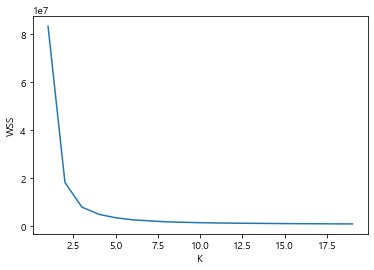

In [53]:
plt.plot(np.arange(1,20), wss)
plt.xlabel('K')
plt.ylabel('WSS')
plt.show()

In [54]:
km = KMeans(n_clusters=3).fit(hit.iloc[:, 2:18])

hit['타자그룹'] = km.labels_
hit['타자그룹'] = hit['타자그룹'].astype('category')

hit['타자그룹'].value_counts()

1    625
0    258
2    215
Name: 타자그룹, dtype: int64

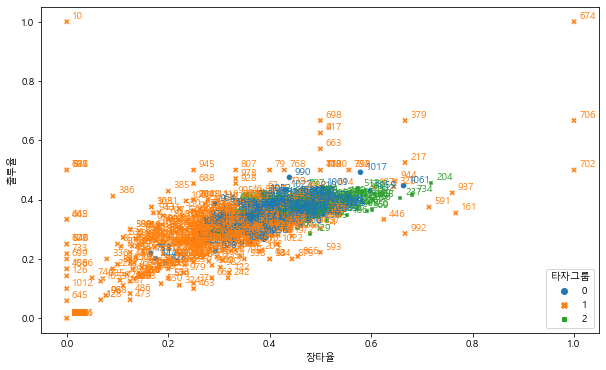

In [55]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="장타율", y="출루율", hue="타자그룹", style="타자그룹", data=hit)
for i in range(hit.shape[0]):
    plt.text(x=hit.장타율[i]+0.01, 
            y=hit.출루율[i]+0.01,
            s=hit.index[i],
            color=sns.color_palette()[hit.타자그룹[i]])
plt.show()

In [56]:
# OPS를 구축하는 장타율과 출루율의 비율 정도에 따라 군집이 나눠짐을 확인.(이상치 제외)
# 0 : 출루율 > 장타율
# 1 : 출루율 = 장타율
# 2 : 출루율 < 장타율

### hit_log 데이터 

In [57]:
hit_log = pd.read_csv('data/hit_log.csv', index_col=0) # 타자 당 날짜별 기록

In [58]:
hts = hts.merge(player.drop('팀코드', axis=1), on=['선수코드', '연도'], how='left')

In [59]:
# hit_log 데이터에 선수 팀 생성
# hts 데이터의 상대팀 코드 열 사용

In [60]:
hit_log['상대팀코드'] = hit_log['상대'].apply(lambda x : 'KT' if ('KT' in x)
                                       else 'LG' if ('LG' in x)
                                       else 'NC' if ('NC' in x)
                                       else 'HT' if ('KIA' in x)
                                       else 'SK' if (('SK' in x) or ('SSG' in x))
                                       else 'SS' if ('삼성' in x)
                                       else 'LT' if ('롯데' in x)
                                       else 'OB' if ('두산' in x)
                                       else 'HH' if ('한화' in x)
                                       else 'WO')

In [61]:
hit_log['날짜'] = hit_log['연도'].astype(int).astype(str) + '-' + hit_log['ss'].astype(str)

In [62]:
hts['날짜'] = hts['날짜'].astype(str)

In [63]:
hit_log = hit_log.merge(hts[['상대팀코드', '팀코드', '날짜']].drop_duplicates(), on=['상대팀코드', '날짜'], how='left')

In [64]:
hit_log['스코어'] = hit_log['결과'].apply(lambda x : x.split(' ')[1]) 
hit_log['결과'] = hit_log['결과'].apply(lambda x : x.split(' ')[0]) 

In [65]:
hit_log

,ss,상대,결과,타순,P,선발,타수,득점,안타,2타,...,투구,avLl,RE24,WPA,선수명,연도,상대팀코드,날짜,팀코드,스코어
0,07-19,@KT,L,8,PH,0,1,0,1,0,...,2,2.61,0.95,0.149,김창혁,2018.0,KT,2018-07-19,HH,7:8
1,07-22,@삼성,L,8,C,1,3,0,0,0,...,9,1.03,-1.33,-0.078,김창혁,2018.0,SS,2018-07-22,HH,4:5
2,09-06,@KT,W,5,PR,0,2,1,1,1,...,3,0.02,-0.25,-0.001,김창혁,2018.0,KT,2018-09-06,HH,9:2
3,09-07,@KT,L,6,PH,0,1,0,0,0,...,6,0.00,-0.12,0.000,김창혁,2018.0,KT,2018-09-07,HH,4:12
4,09-09,@LG,L,8,PH,0,2,0,0,0,...,9,0.51,-0.44,-0.026,김창혁,2018.0,LG,2018-09-09,HH,5:8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63984,08-11,SSG,W,5,3B,1,5,1,1,0,...,22,0.32,-0.74,-0.037,문보경,2021.0,SK,2021-08-11,NaN,12:5
63985,08-13,롯데,L,5,3B,1,3,0,1,0,...,8,1.04,-0.43,-0.044,문보경,2021.0,LT,2021-08-13,NaN,0:2
63986,07-02,@KT,L,8,1B,1,3,0,1,0,...,15,1.32,-0.28,0.019,이명기,2021.0,KT,2021-07-02,WO,1:4
63987,07-04,@KT,L,8,1B,1,2,0,0,0,...,18,1.15,-0.84,-0.055,이명기,2021.0,KT,2021-07-04,WO,3:12


In [66]:
# 데이터 정기적으로 업뎃 필요

### game_log 데이터

In [67]:
game_log = pd.read_csv('data/game_log.csv', index_col=0) # 경기 로그
game_log = game_log.loc[-game_log['투수'].isnull(), :].reset_index(drop=True)

In [68]:
game_log['타석번호'] = game_log['타자'].apply(lambda x : x.split(' ')[0])
game_log['타자'] = game_log['타자'].apply(lambda x : x.split(' ')[1])

In [69]:
game_log['date'] = pd.to_datetime(game_log['date'])
game_log['연도'] = game_log.date.dt.year
game_log['월'] = game_log.date.dt.month
game_log['일'] = game_log.date.dt.day

In [70]:
game_log['결과'] = game_log['결과'].apply(lambda x : x.split(':')[1] if ':' in x
                                     else x)
game_log['던진공개수'] = game_log['P'].apply(lambda x : str(x)[0])
game_log['볼카운트'] = game_log['P'].apply(lambda x : str(x)[2:5])
game_log.drop('P', axis=1, inplace=True)

In [71]:
game_log

,이닝,투수,타자,결과,이전상황,이후상황,LEV,REs,REa,WPe,WPa,date,타석번호,연도,월,일,던진공개수,볼카운트
0,1초,켈리,민병헌,삼진 아웃,무사 0:0,1사 0:0,0.87,0.555,-0.258,52.2%,-0.022,2018-03-24,1,2018,3,24,4,2-1
1,1초,켈리,손아섭,3루수 뜬공,1사 0:0,2사 0:0,0.62,0.297,-0.180,53.8%,-0.016,2018-03-24,2,2018,3,24,2,0-1
2,1초,켈리,전준우,삼진 아웃,2사 0:0,이닝종료 0:0,0.40,0.117,-0.117,54.8%,-0.010,2018-03-24,3,2018,3,24,6,2-3
3,1말,김원중,정진기,1루수 땅볼,무사 0:0,1사 0:0,0.87,0.555,-0.258,52.6%,-0.022,2018-03-24,1,2018,3,24,5,2-1
4,1말,김원중,한유섬,1루수 직선타 아웃,1사 0:0,2사 0:0,0.62,0.297,-0.180,51.0%,-0.015,2018-03-24,2,2018,3,24,4,1-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3191071,10말,손승락,최정,삼진 아웃,무사 8:6,1사 8:6,1.83,0.555,-0.258,4.4%,-0.047,2021-07-11,6,2021,7,11,3,2-0
3191072,10말,손승락,김강민,좌익수 안타,1사 8:6,1사 1루 8:6,1.19,0.297,0.276,10.6%,0.061,2021-07-11,7,2021,7,11,2,0-1
3191073,10말,손승락,최항,볼넷,1사 1루 8:6,"1사 1,2루 8:6",2.59,0.573,0.398,19.8%,0.093,2021-07-11,8,2021,7,11,9,2-3
3191074,10말,손승락,박정권,1루수 땅볼,"1사 1,2루 8:6","2사 2,3루 8:6",4.70,0.971,-0.337,14.5%,-0.054,2021-07-11,9,2021,7,11,6,2-3
